In [ ]:
!pip install -q duckdb  --pre --upgrade
!pip install -q pyarrow --upgrade
!pip install geopandas  --upgrade
import sys
sys.exit(0)

In [16]:
import duckdb
import urllib.request
import zipfile
import os
duckdb.sql("INSTALL spatial; LOAD spatial;")

In [3]:
population_url = "https://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"
local_population_file = "world_population.csv.zip"  # Renamed to reflect it's a zip file
urllib.request.urlretrieve(population_url, local_population_file)
extract_dir = "/lakehouse/default/Files/zip"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(local_population_file, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

url = "https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson"
local_file = "/lakehouse/default/Files/countries.geojson"
urllib.request.urlretrieve(url, local_file)

('/lakehouse/default/Files/countries.geojson',
 <http.client.HTTPMessage at 0x7fc3a079e910>)

In [4]:
duckdb.sql(f"""
                CREATE OR REPLACE view population AS
                SELECT * from read_csv('{extract_dir}/API*.csv',header=1,normalize_names=1);
                from population limit 4
          """).show(max_width=100)

┌──────────────────────┬──────────────┬───────────────────┬───┬───────────┬───────────┬──────────┐
│     country_name     │ country_code │  indicator_name   │ … │   _2023   │   _2024   │ column69 │
│       varchar        │   varchar    │      varchar      │   │   int64   │   int64   │ varchar  │
├──────────────────────┼──────────────┼───────────────────┼───┼───────────┼───────────┼──────────┤
│ Aruba                │ ABW          │ Population, total │ … │    107359 │    107624 │ NULL     │
│ Africa Eastern and…  │ AFE          │ Population, total │ … │ 750503764 │ 769294618 │ NULL     │
│ Afghanistan          │ AFG          │ Population, total │ … │  41454761 │  42647492 │ NULL     │
│ Africa Western and…  │ AFW          │ Population, total │ … │ 509398589 │ 521764076 │ NULL     │
├──────────────────────┴──────────────┴───────────────────┴───┴───────────┴───────────┴──────────┤
│ 4 rows                                                                    70 columns (6 shown) │
└─────────

In [5]:
duckdb.sql(f"""
                  CREATE OR REPLACE view countries AS
                  SELECT * FROM ST_Read('{local_file}');
                  from countries limit 4
            """).show(max_width=100)

┌───────────┬───────────────────┬───────────────────┬──────────────────────────────────────────────┐
│   name    │ ISO3166-1-Alpha-3 │ ISO3166-1-Alpha-2 │                     geom                     │
│  varchar  │      varchar      │      varchar      │                   geometry                   │
├───────────┼───────────────────┼───────────────────┼──────────────────────────────────────────────┤
│ Indonesia │ IDN               │ ID                │ MULTIPOLYGON (((117.703608 4.163415, 117.7…  │
│ Malaysia  │ MYS               │ MY                │ MULTIPOLYGON (((117.703608 4.163415, 117.6…  │
│ Chile     │ CHL               │ CL                │ MULTIPOLYGON (((-69.510089 -17.506588, -69…  │
│ Bolivia   │ BOL               │ BO                │ POLYGON ((-69.510089 -17.506588, -69.51009…  │
└───────────┴───────────────────┴───────────────────┴──────────────────────────────────────────────┘



In [6]:
# Save to Parquet with geometry preserved
duckdb.sql("""
    COPY (select name,geom,_2024 as pop from countries join population on "ISO3166-1-Alpha-3" = country_code)   TO '/lakehouse/default/Files/countries.parquet' (FORMAT PARQUET);
""")

In [14]:
duckdb.sql("select path_in_schema ,type,geo_bbox, geo_types   from parquet_metadata( '/lakehouse/default/Files/countries.parquet')").show(max_width=150)

┌────────────────┬────────────┬────────────────────────────────────────────────────────────────────────────────────────────┬─────────────────────────┐
│ path_in_schema │    type    │                                          geo_bbox                                          │        geo_types        │
│    varchar     │  varchar   │ struct(xmin double, xmax double, ymin double, ymax double, zmin double, zmax double, mmi…  │        varchar[]        │
├────────────────┼────────────┼────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────────────┤
│ name           │ BYTE_ARRAY │ NULL                                                                                       │ NULL                    │
│ geom           │ BYTE_ARRAY │ {'xmin': -180.0, 'xmax': 180.0, 'ymin': -55.918504, 'ymax': 83.634101, 'zmin': NULL, 'zm…  │ [polygon, multipolygon] │
│ pop            │ INT64      │ NULL                                                          

In [18]:
duckdb.sql("select geom, ST_AsText(geom) as wkt  from '/lakehouse/default/Files/countries.parquet' ").show(max_width=150)

┌──────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         geom         │                                                             wkt                                                             │
│       geometry       │                                                           varchar                                                           │
├──────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ POLYGON ((-69.9969…  │ POLYGON ((-69.996938 12.577582, -69.936391 12.531724, -69.924672 12.519232, -69.915761 12.497016, -69.880198 12.453559, -…  │
│ POLYGON ((74.54235…  │ POLYGON ((74.542354 37.021669, 74.547418 37.015675, 74.549279 37.008931, 74.548142 37.001644, 74.544214 36.994022, 74.537…  │
│ MULTIPOLYGON (((13…  │ MULTIPOLYGON (((13.073703 -4.635323, 13.065331 -4.663952, 13.029571 -

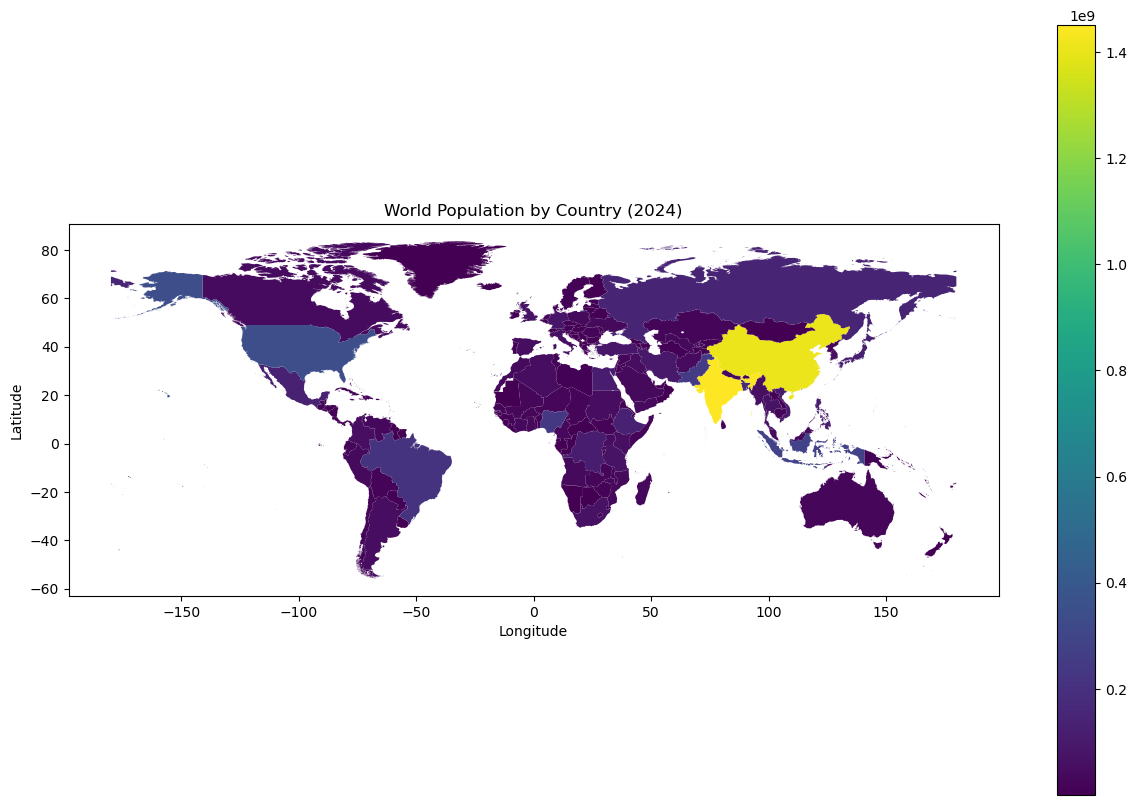

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
gdf = gpd.read_parquet('/lakehouse/default/Files/countries.parquet')
fig, ax = plt.subplots(1, 1, figsize=(15, 10))  # Increase figure size
gdf.plot(column='pop', ax=ax, legend=True)  # Add legend
ax.set_title('World Population by Country (2024)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()